<h2>DataScientist Task solution, Uladzislau Sataneuski</h2>

Here is a plan of what we will actually do:

1) Brief exploratory data analysis to understand data. <br>
2) Define and implement evaluation metric to compare our solutions. <br>
3) Implement few scoring formulas and compare them.
4) Results discussion.

<h3> Exploratory data analysis </h3>

Reading data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import base as sklearn_base
import constants
import evaluation
%matplotlib inline

In [2]:
!head product_scoring.csv

product_id,category_id,cpc,clicks,views
6288767857890040299,7234842626579207420,1.0999999632755684,0.0,26.0
7511865592050261319,3751288961258999757,1.7999998626303444,0.0,156.0
124988842461858786,5924358085291389806,1.6399996427528003,2.0,44.0
1943562212212540244,7234842626579207420,1.0999996194276516,0.0,
4896302356121240191,7234842626579207420,1.0999987098488406,0.0,
1067762062849714419,8847485355484130425,1.639998254871153,5.0,120.0
5054781576529716516,7234842626579207420,1.0999979029817177,0.0,
9081793091528551090,8757232218924067765,1.699997697538757,0.0,
6720608310976529092,1923544693465519030,1.6599970579580705,0.0,21.0


In [3]:
data = pd.read_csv('product_scoring.csv', dtype={'product_id': str, 'category_id': str, 'cpc': np.double, 'clicks': np.int64, 'views': np.float64})
data.views = data.views.fillna(0).astype(np.int64)
data.head(10)

,product_id,category_id,cpc,clicks,views
0,6288767857890040299,7234842626579207420,1.100000,0,26
1,7511865592050261319,3751288961258999757,1.800000,0,156
2,124988842461858786,5924358085291389806,1.640000,2,44
3,1943562212212540244,7234842626579207420,1.100000,0,0
4,4896302356121240191,7234842626579207420,1.099999,0,0
5,1067762062849714419,8847485355484130425,1.639998,5,120
6,5054781576529716516,7234842626579207420,1.099998,0,0
7,9081793091528551090,8757232218924067765,1.699998,0,0
8,6720608310976529092,1923544693465519030,1.659997,0,21
9,8661966909908175139,1923544693465519030,1.659995,0,59


It's easy to see that we have items in our collection having 0 views.

Here we just look at data size and double check that IDs are unique.

In [4]:
print("data shape:", data.shape)
print("different products:", data.product_id.nunique())

data shape: (10000, 5)
different products: 10000


Let's look at how popular our categories are

In [5]:
categories_value_counts = data.category_id.value_counts()

In [6]:
categories_value_counts.head()

7234842626579207420    4000
8757232218924067765     675
1685543589975630639     484
1923544693465519030     466
5165268297756540484     339
Name: category_id, dtype: int64

In [7]:
categories_value_counts.describe()

count     170.000000
mean       58.823529
std       315.819763
min         1.000000
25%         3.250000
50%        10.000000
75%        24.000000
max      4000.000000
Name: category_id, dtype: float64

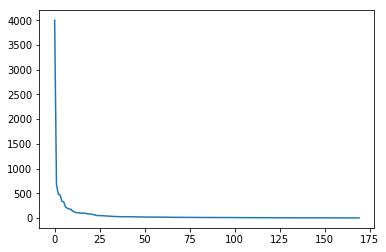

In [8]:
plt.plot(range(len(categories_value_counts)), categories_value_counts)

We see that there is one group having 4000 products and lots of small groups. This means that we won't be able to calculate robust statistics (like average click probability) for all of them.

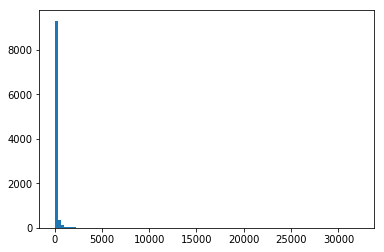

In [9]:
_ = plt.hist(data.views, bins=100)

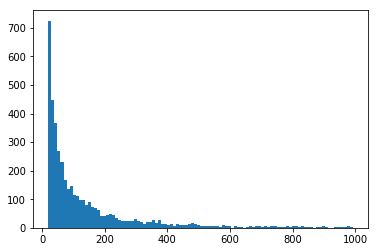

In [10]:
_ = plt.hist(data.views[(data.views >= 1) & (data.views <= 1000)], bins=100)

In [11]:
(data.views == 0).sum()

5561

Here we see that more than a half of products have been never shown. In means that our scoring function should handle these products well.
We also see that despite it we have some products with really huge views count.

Let's have a look at the click probability for the whole dataset.

In [12]:
data.clicks.sum() / data.views.sum()

0.020341417402632529

Let's have a look at cpc distribution.

(array([ 4000.,     0.,     0.,  2619.,  1762.,  1104.,   278.,    25.,
            0.,   212.]),
 array([ 1.09425665,  1.24480941,  1.39536218,  1.54591494,  1.69646771,
         1.84702047,  1.99757324,  2.148126  ,  2.29867877,  2.44923153,
         2.5997843 ]),
 <a list of 10 Patch objects>)

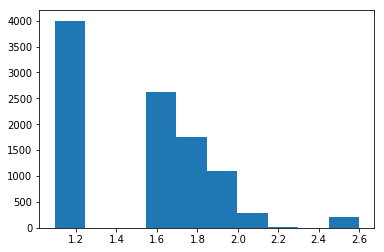

In [13]:
plt.hist(data.cpc)

Here we see strange gaps in our distribution. Let's have a look at it in more detail.

In [14]:
items_mask = ((data.cpc > 1.2))
print(data.views[items_mask].describe())

count     6000.000000
mean       186.410167
std        834.256770
min          0.000000
25%          0.000000
50%         36.000000
75%        132.000000
max      32168.000000
Name: views, dtype: float64


In [15]:
items_mask = ((data.cpc <= 1.2))
print(data.views[items_mask].describe())

count    4000.000000
mean       12.461250
std        46.770283
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1188.000000
Name: views, dtype: float64


We see that we have very different statistics for these classes. It's also interesging that there are exactly 4000 products in it, like in the most popular category. Let's check.

In [16]:
data.cpc[data.category_id == 7234842626579207420].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: cpc, dtype: float64

Yes. we see that all of them have cpc < 1.2. It means that we have a huge group of products having relatively small cpc and the same category. They also have smaller views count. It probably means that it's because of some logical (business) reasons that we don't know.

Let's look at click probability distribution over products having lots of views.

(array([  1.46700000e+03,   3.32000000e+02,   8.20000000e+01,
          2.60000000e+01,   1.00000000e+01,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.02336825,  0.0467365 ,  0.07010475,  0.09347301,
         0.11684126,  0.14020951,  0.16357776,  0.18694601,  0.21031426,
         0.23368251]),
 <a list of 10 Patch objects>)

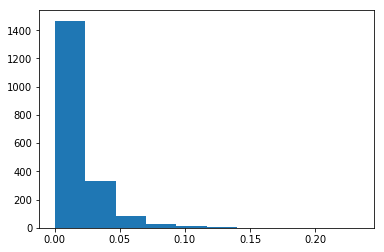

In [17]:
plt.hist((data.clicks / (data.views + 0.1))[data.views >= 100])

We see that some of them are much more relevant for users than others.

Let's have a look at cpc and click probability together. 

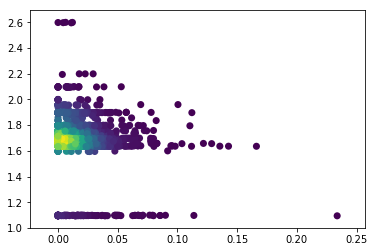

In [18]:
items_mask = (data.views >= 100)
x=(data.clicks / (data.views + 0.1))[items_mask]
y=data.cpc[items_mask]
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()

We see that we have only few "outliers" here, which is a good news for us.

<h3> Defining scoring function </h3>

Actually, scoring function highly depends on business needs and currently we don't know them well. For example, the most obvious one is money, so we should optimize expected amount of money we get for clicks after showing recommendations. We will optimise that, but there could be different objectives like probability of click, because if user clicks on our recommendation, it's useful for him, so we'll have happy customers with lower retention. It could be also objective to show different new products that haven't been shown to collect data about different items.

In our case let's define objective function as follows (we'll redefine nDCG scoring function):

$$DCG = \sum_i\frac{p_i \cdot cpc_i}{log(i+1)}$$

$$nDCG = \frac{DCG}{IDCG}$$

Where $p_i$ is a probability for item in test set to be clicked and $cpc_i$ is a cost per click for this item. We'll try to optimize $nDCG$.

Now we need to define how actually this function is calculated. So we have to define validation scheme. Of course, we cannot do in straightforward way (splitting rows of current csv). Instead of it we'll do cross validation over all views, so we'll split pairs (product_id, user_clicked), where user_clicked is a boolean indicating if user clicked. And we'll calculate it directly:

1) For product with A views and P clicks we'll create B pairs (product_id, True) and A - B pairs (product_id, False). <br>
2) We'll do cross-validation over these pairs. At each step of croll validation we'll combine our pairs into format we've had at the beginning (having count of views and clicks) and pass to algirithm.

Of course, it's not an efficient procedure, but I think it's relatively easy to implement and speed could be improved if needed or algorithm could be approximated (for example, we can identify amount of product viewed and clicked counts for train and test by sampling from binomial distribution or its approximation).

<h3>Formulas evaluation</h3>

Now, let's evaluate few models. The most obvious one is random model, assigning random score for each product.

In [19]:
class RandomModel(sklearn_base.BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        np.random.seed(42)
        return np.random.ranf(len(X))

In [20]:
evaluation.evaluate(RandomModel(), data)

EvaluationResults(scores=array([ 0.53289584,  0.50911644,  0.49078954,  0.52462308,  0.52284123,
        0.50658949,  0.4954208 ,  0.50348797,  0.47921536,  0.53078096]), mean=0.5095760706285628, std=0.017079547887464529)

Model, assigning score equal to CPC.

In [21]:
class CPCModel(sklearn_base.BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return X.cpc

In [22]:
evaluation.evaluate(CPCModel(), data)

EvaluationResults(scores=array([ 0.55013212,  0.50701124,  0.49257735,  0.54060066,  0.51724421,
        0.50965299,  0.51304838,  0.50693182,  0.48357495,  0.51886908]), mean=0.51396427983878945, std=0.01884293567352896)

Model estimating probability of click using highest likelihood formula and then multiplies estimated probability by CPC.

In [23]:
class TrivialEstimatedProfitModel(sklearn_base.BaseEstimator):
    def __init__(self):
        self._score = None

    def fit(self, X, y=None):
        X = X.set_index(constants.PRODUCT_ID)
        self._score = X.clicks / (X.views + 1e-6)
        return self

    def predict(self, X):
        estimated_probabilities = X.product_id.map(self._score).fillna(0.0)
        estimated_profit = estimated_probabilities * X.cpc
        return estimated_profit

In [24]:
trivial_model = TrivialEstimatedProfitModel()
evaluation.evaluate(trivial_model, data)

EvaluationResults(scores=array([ 0.75830086,  0.69106545,  0.69260688,  0.71003078,  0.68714974,
        0.70971315,  0.71848003,  0.68242423,  0.76773298,  0.71906057]), mean=0.71365646632661384, std=0.027622555162742084)

We see that this model is much better than others as expected.

As we noticed before, we have lot's of items with zero or small amount of views. And we have lots of categories with small number of products. So we need smoothing to estmate our statistics more robust.

To do that, we'll use the following formula:

Let $P$ be a set of products, $c_p$ be product $p$ category.

$nc(condition)$ - total number of clicks for products satisfying condition and $nv(condition)$ - total number of views for product satisfying condition. Let $prior$ be prior probability of click. 

$$prior = \frac{nc(p \in P)}{nv(p \in P)}$$

Let $cat_c$ be estimated probability of product with category $c$ to be clicked. We, ll estimate $cat_c$ as:
$$cat_c = \frac{nc(p|c_p=c) + \alpha * pp}{nv(p|c_p=c) + \alpha}$$

Let $prod_p$ be estimated probability of click on product $p$, we'll estimate $prod_p$ as:
$$prod_p = \gamma \cdot \frac{nc(p) + \beta * cat_{p_c}}{nv(p) + \beta} + (1 - \gamma) \cdot cat_{p_c} \cdot discount$$

Here $\alpha$, $\beta$, $\gamma$ and $discount$ are parameters. This is usual additive smoothing scheme with linear interpolation and discounting ensuring that product click has more weigth in this sum. I've also tried absolute discounting, but it didn't work better.

In [25]:
_CATEGORY_PROBABILITY = 'category_probability'


class SmoothedEstimatedProfitModel(sklearn_base.BaseEstimator):
    def __init__(self, alpha, beta, gamma, discount):
        self._product_data = None
        self._category_data = None
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.discount = discount

    def fit(self, X, y=None):
        X = X.set_index(constants.PRODUCT_ID)
        self._product_data = X
        self._category_data = X.groupby(constants.CATEGORY_ID).sum()
        self._all_probability = X.clicks.sum() / X.views.sum()
        return self

    def predict(self, X):
        category_probability = (
            (self._category_data.clicks + self._all_probability * self.alpha) / 
            (self._category_data.views + self.alpha)
        )

        X_extended = X.merge(
            self._product_data[[constants.VIEWS, constants.CLICKS]],
            left_on=constants.PRODUCT_ID,
            right_index=True,
            how='left',
        ).fillna(0)        

        X_extended[_CATEGORY_PROBABILITY] = X_extended.category_id.map(category_probability)

        product_click_probability = ((X_extended.clicks + X_extended.category_probability * self.beta) 
                                     / (X_extended.views + self.beta))

        product_click_probability = (
            self.gamma * product_click_probability + 
            (1 - self.gamma) * X_extended.category_probability * self.discount
        )

        return (product_click_probability * X_extended.cpc)[X.index]

Playing with parameters I have found solution that is just slightly better than trivial one.

In [26]:
smoothed_model = SmoothedEstimatedProfitModel(alpha=100.0, beta=1e-6, gamma=0.9, discount=0.9)
evaluation.evaluate(smoothed_model, data)

EvaluationResults(scores=array([ 0.75813723,  0.69102417,  0.69301048,  0.70991352,  0.68759377,
        0.70930072,  0.71843812,  0.68328254,  0.76803482,  0.71960247]), mean=0.7138337849027605, std=0.027507721764266999)

Let's save results. Despite having metric a bit worse than parameters before, I'd better choose $\beta=50$ in submission. I'll explain my opinion later in results discussion section.

In [37]:
data['trivial_score'] = trivial_model\
    .fit(data).predict(data[[constants.PRODUCT_ID, constants.CATEGORY_ID, constants.CPC]])
data['smoothed_score'] = SmoothedEstimatedProfitModel(alpha=100.0, beta=50, gamma=0.9, discount=0.9)\
    .fit(data).predict(data[[constants.PRODUCT_ID, constants.CATEGORY_ID, constants.CPC]])

In [38]:
data.set_index(constants.PRODUCT_ID).to_csv('results.csv')

In [45]:
data.sort_values('smoothed_score', ascending=False).head(50)

,product_id,category_id,cpc,clicks,views,trivial_score,smoothed_score
8347,7971606985530370322,3151234738806572779,1.835173,13,42,0.568030,0.261064
7830,4929311323920775984,5165268297756540484,1.635477,53,319,0.271725,0.217223
4374,1873430933095548887,1923544693465519030,1.657496,9,23,0.648585,0.214883
6384,7448237091607706733,4423498402721644859,1.636293,97,716,0.221677,0.192055
2418,4953325780531960527,1923544693465519030,1.658627,16,89,0.298180,0.189979
1817,355688978800763799,1923544693465519030,1.658973,8,26,0.510453,0.187095
6769,2074011348493206048,1923544693465519030,1.656056,62,482,0.213020,0.181346
1044,7600695130221092005,8432810112255698627,2.099385,6,22,0.572559,0.178285
5569,399824603127141136,6860450697281257066,1.896783,10,57,0.332769,0.173854
9773,2462016142026349552,7234842626579207420,1.094380,29,124,0.255944,0.172002


<h3> Results discussion</h3>

After manual review of algorithm results, smoothed algorithm results looks much better than trivial one despite that trivial has even better score. At first, smoothed results have relatively high results for not shown products, so they could be probably shown and clicks could be collected.

The metric proposed is able to differentiate really bad or random algorithm from meaningful, but is not ideal, because trivial algorithm has relatively high value despite having very strange predictions like zeros for unseen items.

The solution in this situation is having lots of diffent metrics and looking at all of them preventing huge degradation of one of them. For example, after adding log loss for estimated probability (and weighted according to CPC), trivial algorithm will be easily identified as bad one.

What could be improved next:

1) More metrics and better main objective function definition. <br>
2) More different smoothing formulas could be tried. <br>
3) Results could be evaluated as the whole list instead of summing over items. It could improve results diversity. <br>
4) More features and data could be used. <br>
5) If this recommendation list is static we can consider our task as a multihanded bandit problem. <br>
6) Personalization can be done (if possible).